In [5]:

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3


#train_hawker_dir = '/content/drive/My Drive/hawker'

hawker_dir = '/content/drive/My Drive/hawker'
#valid_hawker_dir = '/content/drive/My Drive/hawker_validate'

from google.colab import drive
drive.mount('/content/drive')

class_labels = os.listdir(hawker_dir)

print("Class labels:", class_labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class labels: ['fish_soup', 'bak_chor_mee', 'laksa', 'curry_puff', 'kaya_toast', 'chicken_rice']


In [6]:
data_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
   # featurewise_center=True,
    rotation_range=300,  # Randomly rotate images by 20 degrees
    width_shift_range=0.5,  # Randomly shift images horizontally by 10%
    height_shift_range=0.5,  # Randomly shift images vertically by 10%
    shear_range=0.2,  # Apply shear transformation with a shear intensity of 0.2
    zoom_range=0.5,  # Randomly zoom images by 20%
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,
    validation_split=0.3,
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)

#print(f"train_hawker_dir:" +train_hawker_dir)
#print(f"valid_hawker_dir:" +valid_hawker_dir)

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator

print(hawker_dir)
train_generator = data_generator.flow_from_directory(
       # train_hawker_dir,  # This is the source directory for training images
        hawker_dir,
        target_size=(224, 224),# All images will be resized to 300x300
        batch_size=10,
        class_mode='categorical'
        # Since we use binary_crossentropy loss, we need binary labels
       )

validation_generator = validation_datagen.flow_from_directory(
        #validate_hawker_dir,  # This is the source directory for validation images

        hawker_dir,
        target_size=(224, 224),# All images will be resized to 300x300
        batch_size=10,
        class_mode='categorical'
        # Since we use binary_crossentropy loss, we need binary labels
        )


#https://drive.google.com/drive/folders/1a1p31ogK-IspJCOiliX9X9zx9ESwBM5v?usp=sharing


/content/drive/My Drive/hawker
Found 4964 images belonging to 6 classes.
Found 4964 images belonging to 6 classes.


In [7]:


pre_trained_model = InceptionV3(input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet')

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop


# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
#x = layers.Dense(1024, activation='relu')(x)
x=layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

#tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

x=layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (len(class_labels), activation='softmax')(x)

#tf.keras.layers.Dense(len(class_names),kernel_regularizer=tf.keras.regularizers.l2(0.0001))

model = Model( pre_trained_model.input, x)


# Set training parameters
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

Epoch 1/100
100/100 [==============================] - 582s 6s/step - loss: 1.7678 - accuracy: 0.2610 - val_loss: 1.7789 - val_accuracy: 0.3000
Epoch 2/100
100/100 [==============================] - 556s 6s/step - loss: 1.6850 - accuracy: 0.3190 - val_loss: 1.6233 - val_accuracy: 0.3500
Epoch 3/100
100/100 [==============================] - 554s 6s/step - loss: 1.6399 - accuracy: 0.3490 - val_loss: 1.3078 - val_accuracy: 0.6500
Epoch 4/100
100/100 [==============================] - 560s 6s/step - loss: 1.4978 - accuracy: 0.4296 - val_loss: 0.9323 - val_accuracy: 0.7000
Epoch 5/100
100/100 [==============================] - 566s 6s/step - loss: 1.4881 - accuracy: 0.4150 - val_loss: 1.1236 - val_accuracy: 0.5500
Epoch 6/100
100/100 [==============================] - 553s 6s/step - loss: 1.3860 - accuracy: 0.4779 - val_loss: 0.8931 - val_accuracy: 0.6500
Epoch 7/100
100/100 [==============================] - 559s 6s/step - loss: 1.2986 - accuracy: 0.5180 - val_loss: 0.8390 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


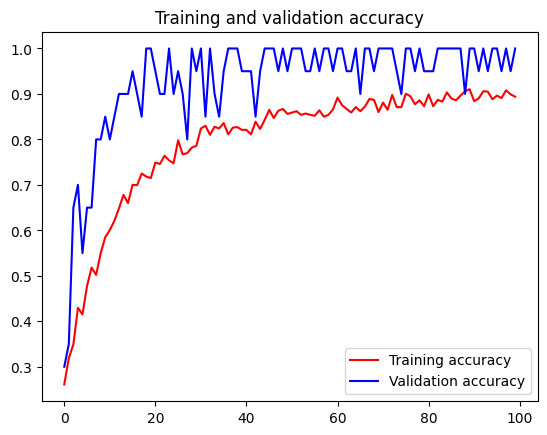

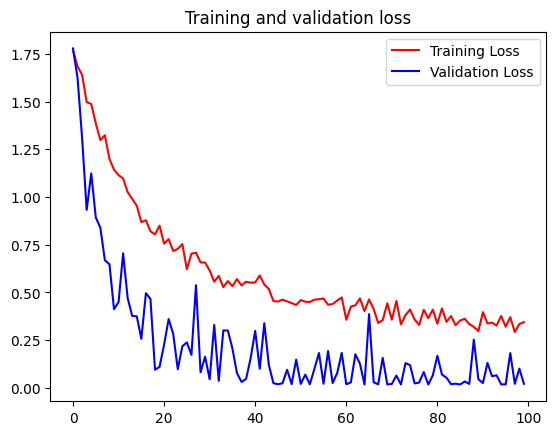

In [8]:

# Constant for epochs
EPOCHS = 100

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100, #400 images = batch_size * step 400= 10
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=2
)


model.save('/content/drive/My Drive/models/l2onlyakan_v1.h5')

import matplotlib.pyplot as plt

# Plot the model results ya
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()